In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("RomanicBanglaSentiment.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Drop missing values
df.dropna(inplace=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['text']
y = df['sentiment']

# Encode sentiment labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create Hugging Face Dataset
hf_dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load tokenizer and model
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(le.classes_)
)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

hf_dataset = hf_dataset.map(tokenize_function, batched=True)
hf_dataset = hf_dataset.remove_columns(['text']).rename_column('label', 'labels')
hf_dataset.set_format('torch')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Metrics function
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset['train'],
    eval_dataset=hf_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Predict on test set
predictions_output = trainer.predict(hf_dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Classification report (with label fix)
report = classification_report(
    true_labels,
    predictions,
    target_names=le.classes_,
    labels=list(range(len(le.classes_)))
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Dataset Shape: (4999, 3)
   Unnamed: 0                                               text  sentiment
0           0   bl theke apnader sathe sorasori kotha bolbo p...        0.0
1           1   Achcha amar gp sim ta off na on ei ta dekar c...        0.0
2           2   5 tk 500 mb dial *5000*150# offer ta koto din...        0.0
3           3                   gp te 78 takar recharge ki hobe         0.0
4           4   gp te advance balance die mb kina jai na kn? ...        2.0


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3998 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 5494.56 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\User

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.477900,0.553645,0.829000,0.800170
2,0.411800,0.432083,0.833000,0.816380
3,0.454300,0.420640,0.838000,0.826668
4,0.164300,0.619691,0.819000,0.818398
5,0.306100,0.495822,0.838000,0.818711
6,0.156800,0.602141,0.816000,0.817112
7,0.086400,0.832481,0.820000,0.822036
8,0.065700,0.859165,0.825000,0.819989
9,0.194300,1.003513,0.825000,0.829603
10,0.045400,0.962625,0.829000,0.829456


Evaluation Results: {'eval_loss': 0.420640230178833, 'eval_accuracy': 0.838, 'eval_f1': 0.8266675930817465, 'eval_runtime': 3.6967, 'eval_samples_per_second': 270.515, 'eval_steps_per_second': 17.042, 'epoch': 10.0}


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.float64' has no len()

In [3]:
trainer.save_model('XLNet')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset Shape: (4999, 3)
   Unnamed: 0                                               text  sentiment
0           0   bl theke apnader sathe sorasori kotha bolbo p...        0.0
1           1   Achcha amar gp sim ta off na on ei ta dekar c...        0.0
2           2   5 tk 500 mb dial *5000*150# offer ta koto din...        0.0
3           3                   gp te 78 takar recharge ki hobe         0.0
4           4   gp te advance balance die mb kina jai na kn? ...        2.0


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3998 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 22205.83 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Use

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.444700,0.550862,0.825000,0.799964
2,0.395500,0.455541,0.823000,0.810601
3,0.420100,0.426676,0.835000,0.817922
4,0.183200,0.689071,0.819000,0.822126
5,0.216600,0.531814,0.831000,0.828256
6,0.130800,0.709372,0.841000,0.831925
7,0.110200,0.809116,0.843000,0.837483
8,0.068600,0.868616,0.835000,0.833570
9,0.159800,0.985589,0.832000,0.828291
10,0.040500,1.016966,0.832000,0.826218


Evaluation Results: {'eval_loss': 0.426676481962204, 'eval_accuracy': 0.835, 'eval_f1': 0.8179221186277822, 'eval_runtime': 12.038, 'eval_samples_per_second': 83.07, 'eval_steps_per_second': 5.233, 'epoch': 10.0}


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\ana

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       778
         1.0       0.50      0.03      0.06        32
         2.0       0.64      0.55      0.59       190
         3.0       0.00      0.00      0.00         0

    accuracy                           0.83      1000
   macro avg       0.50      0.38      0.39      1000
weighted avg       0.82      0.83      0.82      1000



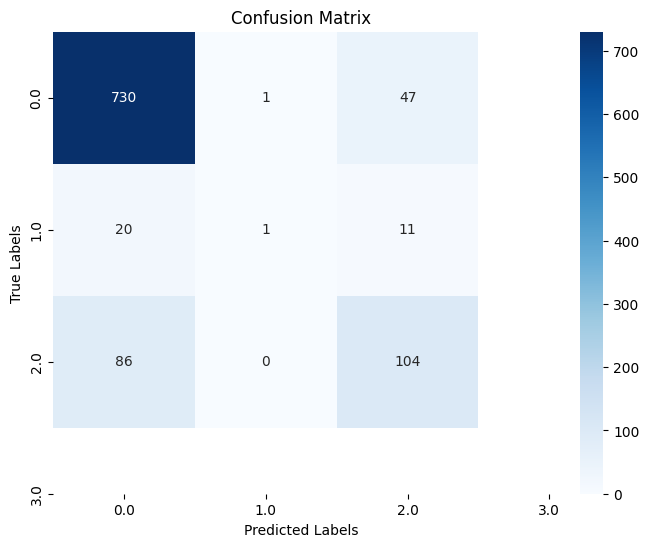

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("RomanicBanglaSentiment.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Drop missing values
df.dropna(inplace=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['text']
y = df['sentiment']

# Encode sentiment labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create Hugging Face Dataset
hf_dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load tokenizer and model
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(le.classes_)
)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

hf_dataset = hf_dataset.map(tokenize_function, batched=True)
hf_dataset = hf_dataset.remove_columns(['text']).rename_column('label', 'labels')
hf_dataset.set_format('torch')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Metrics function
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset['train'],
    eval_dataset=hf_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Predict on test set
predictions_output = trainer.predict(hf_dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Convert class names to strings to avoid TypeError
class_names = [str(cls) for cls in le.classes_]

# Classification report
report = classification_report(
    true_labels,
    predictions,
    target_names=class_names,
    labels=list(range(len(class_names)))
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
